# CLS 토큰 only

In [4]:
from pathlib import Path
import torch
import torch.nn as nn
import numpy as np
from decord import VideoReader
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import json
from tqdm import tqdm
import sys

# === 파라미터 직접 지정 ===
ROOT = Path(r'D:/golfDataset/dataset')
FUSION_DIR = Path(r'D:/Jabez/golf/fusion')
PER_VIDEO_DIR = FUSION_DIR / 'embedding_data' / 'timesformer' / 'per_video'
PER_VIDEO_DIR.mkdir(parents=True, exist_ok=True)
PRETRAINED = Path(r'D:/timesformer/pretrained/TimeSformer_divST_96x4_224_K600.pyth')
NUM_FRAMES = 96    # 비디오에서 추출할 프레임 수
# 일반적으로 스윙은 2초 이상(jpg 결합이 30fps 기준, 120프레임은 필요)
CLIPS_PER_VID = 2
IMG_SIZE = 224
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

sys.path.append(r'D:/timesformer')
from timesformer.models.vit import TimeSformer

# ImageNet mean/std 사용 (공식 권장)
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
eval_transform = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),  # [0,1], (C,H,W)
    transforms.Normalize(mean, std),
])

def uniform_sample(length, num):
    if length >= num:
        return np.linspace(0, length-1, num, dtype=int)
    return np.pad(np.arange(length), (0,num-length), mode='edge')

def load_clip(path: Path):
    vr = VideoReader(str(path))
    L  = len(vr)
    segs = np.linspace(0, L, CLIPS_PER_VID+1, dtype=int)
    clips = []
    for s,e in zip(segs[:-1], segs[1:]):
        idx = uniform_sample(e-s, NUM_FRAMES) + s
        arr = vr.get_batch(idx).asnumpy()  # (T,H,W,3)
        proc = []
        for frame in arr:
            img = transforms.ToPILImage()(frame)
            img_t = eval_transform(img)
            proc.append(img_t)
        clip = torch.stack(proc, dim=1)  # (C,T,H,W)
        clips.append(clip)
    return clips

# 모델 로드
model = TimeSformer(
    img_size=IMG_SIZE,
    num_frames=NUM_FRAMES,
    num_classes=2,
    attention_type='divided_space_time',
    pretrained_model=str(PRETRAINED)
).to(DEVICE)
for attr in ('head','cls_head'):
    if hasattr(model, attr): setattr(model, attr, nn.Identity())
    if hasattr(model, 'model') and hasattr(model.model, attr):
        setattr(model.model, attr, nn.Identity())
model.eval()

# train, test 폴더 내 balanced_true/false/crop_video/*.mp4 모두 처리
mapping = {'balanced_true': 1, 'false': 0}
all_mp4s = []

for split in ['train', 'test']:
    split_root = ROOT / split
    for cat, lbl in mapping.items():
        vd = split_root / cat / 'crop_video'
        if not vd.exists(): continue
        for mp4 in vd.glob('*.mp4'):
            all_mp4s.append((mp4, lbl, cat, split))

print(f'총 {len(all_mp4s)}개 mp4 처리')

for mp4, lbl, cat, split in tqdm(all_mp4s, desc='Extracting', ncols=80):
    vid = mp4.stem
    out_path = PER_VIDEO_DIR / f'{vid}.npy'
    meta_path = PER_VIDEO_DIR / f'{vid}.json'
    # --- 기존 임베딩이 있어도 무조건 새로 생성 ---
    # if out_path.exists():
    #     continue
    clips = load_clip(mp4)
    feats = []
    for clip in clips:
        c = clip.unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            out = model.model.forward_features(c)
        cls = out[:,0,:] if out.ndim==3 else out
        feats.append(cls.squeeze(0).cpu().numpy())
    emb = np.stack(feats,0).mean(0)
    np.save(out_path, emb)
    meta = {
        'video_id': vid, 'label': lbl, 'category': cat, 'split': split,
        'mp4_path': str(mp4)
    }
    with open(meta_path, 'w', encoding='utf-8') as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)
# ...existing code...


총 2071개 mp4 처리


Extracting: 100%|███████████████████████████| 2071/2071 [37:28<00:00,  1.09s/it]


# CLS 토큰 + 전체 토큰 평균 concat

In [5]:
from pathlib import Path
import torch
import torch.nn as nn
import numpy as np
from decord import VideoReader
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import json
from tqdm import tqdm
import sys

# === 파라미터 직접 지정 ===
ROOT = Path(r'D:/golfDataset/dataset')
FUSION_DIR = Path(r'D:/Jabez/golf/fusion')
PER_VIDEO_DIR = FUSION_DIR / 'embedding_data' / 'timesformer' / 'per_video'
PER_VIDEO_DIR.mkdir(parents=True, exist_ok=True)
PRETRAINED = Path(r'D:/timesformer/pretrained/TimeSformer_divST_96x4_224_K600.pyth')
NUM_FRAMES = 96
CLIPS_PER_VID = 2
IMG_SIZE = 224
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

sys.path.append(r'D:/timesformer')
from timesformer.models.vit import TimeSformer

# ImageNet mean/std 사용 (공식 권장)
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
eval_transform = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

def uniform_sample(length, num):
    if length >= num:
        return np.linspace(0, length-1, num, dtype=int)
    return np.pad(np.arange(length), (0,num-length), mode='edge')

def load_clip(path: Path):
    vr = VideoReader(str(path))
    L  = len(vr)
    segs = np.linspace(0, L, CLIPS_PER_VID+1, dtype=int)
    clips = []
    for s,e in zip(segs[:-1], segs[1:]):
        idx = uniform_sample(e-s, NUM_FRAMES) + s
        arr = vr.get_batch(idx).asnumpy()  # (T,H,W,3)
        proc = []
        for frame in arr:
            img = transforms.ToPILImage()(frame)
            img_t = eval_transform(img)
            proc.append(img_t)
        clip = torch.stack(proc, dim=1)  # (C,T,H,W)
        clips.append(clip)
    return clips

# 모델 로드
model = TimeSformer(
    img_size=IMG_SIZE,
    num_frames=NUM_FRAMES,
    num_classes=2,
    attention_type='divided_space_time',
    pretrained_model=str(PRETRAINED)
).to(DEVICE)
for attr in ('head','cls_head'):
    if hasattr(model, attr): setattr(model, attr, nn.Identity())
    if hasattr(model, 'model') and hasattr(model.model, attr):
        setattr(model.model, attr, nn.Identity())
model.eval()

# train, test 폴더 내 balanced_true/false/crop_video/*.mp4 모두 처리
mapping = {'balanced_true': 1, 'false': 0}
all_mp4s = []
for split in ['train', 'test']:
    split_root = ROOT / split
    for cat, lbl in mapping.items():
        vd = split_root / cat / 'crop_video'
        if not vd.exists(): continue
        for mp4 in vd.glob('*.mp4'):
            all_mp4s.append((mp4, lbl, cat, split))

print(f'총 {len(all_mp4s)}개 mp4 처리')

for mp4, lbl, cat, split in tqdm(all_mp4s, desc='Extracting', ncols=80):
    vid = mp4.stem
    out_path = PER_VIDEO_DIR / f'{vid}.npy'
    meta_path = PER_VIDEO_DIR / f'{vid}.json'
    clips = load_clip(mp4)
    feats = []
    for clip in clips:
        c = clip.unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            out = model.model.forward_features(c)  # (B, T+1, D) or (B, N, D)
        # CLS 토큰
        cls_emb = out[:,0,:] if out.ndim==3 else out
        # 전체 토큰 평균 (CLS 제외)
        if out.ndim == 3 and out.shape[1] > 1:
            mean_emb = out[:,1:,:].mean(dim=1)
        else:
            mean_emb = cls_emb
        # CLS + mean pooling concat
        final_emb = torch.cat([cls_emb, mean_emb], dim=-1).squeeze(0).cpu().numpy()
        feats.append(final_emb)
    emb = np.stack(feats,0).mean(0)
    np.save(out_path, emb)
    meta = {
        'video_id': vid, 'label': lbl, 'category': cat, 'split': split,
        'mp4_path': str(mp4)
    }
    with open(meta_path, 'w', encoding='utf-8') as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)

총 2071개 mp4 처리


Extracting: 100%|█████████████████████████| 2071/2071 [1:15:34<00:00,  2.19s/it]


임베딩 shape: (2070, 1536)
라벨 분포: [ 544 1526]


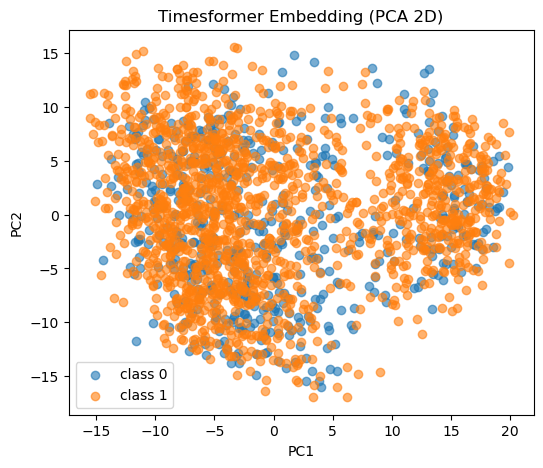

Class 0: mean=[ 0.2836939   0.54935765 -0.2668233  -0.4162406   0.24854822], std=[0.5409441  0.66420525 0.77399254 0.61612993 0.723072  ] ... (앞 5개)
Class 1: mean=[ 0.09939826  0.65709573 -0.19721007 -0.35191628  0.15580006], std=[0.5378226  0.6963092  0.8226516  0.682098   0.66510236] ... (앞 5개)
코사인 유사도 행렬 shape: (2070, 2070)
자기 자신과의 평균 유사도: 1.0000
타 클래스 평균 유사도: 0.5445


In [1]:
from pathlib import Path
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

EMB_DIR = Path(r'D:/Jabez/golf/fusion/embedding_data/timesformer/per_video')

# 모든 npy, json 파일 리스트
npy_files = sorted(EMB_DIR.glob('*.npy'))
json_files = [EMB_DIR / (f.stem + '.json') for f in npy_files]

# 임베딩과 라벨 로드
embs = []
labels = []
for npy_f, json_f in zip(npy_files, json_files):
    emb = np.load(npy_f)
    with open(json_f, encoding='utf-8') as jf:
        meta = json.load(jf)
    embs.append(emb)
    labels.append(meta['label'])

embs = np.stack(embs)  # (N, D)
labels = np.array(labels)

print(f"임베딩 shape: {embs.shape}")  # (N, D)
print(f"라벨 분포: {np.bincount(labels)}")  # 클래스별 개수

# PCA로 2D 시각화
pca = PCA(n_components=2)
embs_2d = pca.fit_transform(embs)
plt.figure(figsize=(6,5))
for lbl in np.unique(labels):
    idx = labels == lbl
    plt.scatter(embs_2d[idx,0], embs_2d[idx,1], label=f'class {lbl}', alpha=0.6)
plt.legend()
plt.title('Timesformer Embedding (PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# 클래스별 평균/분산
for lbl in np.unique(labels):
    mean = embs[labels==lbl].mean(axis=0)
    std = embs[labels==lbl].std(axis=0)
    print(f'Class {lbl}: mean={mean[:5]}, std={std[:5]} ... (앞 5개)')

# 임베딩 간 유사도(코사인) 예시
from sklearn.metrics.pairwise import cosine_similarity
sim = cosine_similarity(embs)
print(f'코사인 유사도 행렬 shape: {sim.shape}')
print(f'자기 자신과의 평균 유사도: {np.mean(np.diag(sim)):.4f}')
print(f'타 클래스 평균 유사도: {np.mean(sim[labels[:,None]!=labels[None,:]]) :.4f}')